# QSAR - Quantitative Structure-Activity Relationship

##### Correlate the structural features of compounds with their biological activities

This notebook investigates the bioactivity of compounds targeting the aryl hydrocarbon receptor (AhR) and builds a predicitive machine learning model based on molecular fingerprint descriptors.

## Workflow

1. Collect dataset from chEMBL about biological activity of AhR: compounds that have been biologically tested for their activity towards the target
2. Process bioactivity data: calculate Lipinski descriptors to evaluate the likelihood of compounds to be a drug-like molecule
3. Exploratory data analysis of Lipinski descriptors to visualize the difference of active and inactive subsets of compounds
4. Calculate Pubchem fingerprint descriptors using PaDEL-Descriptor
5. Use the dataset of molecular descriptors to build a predictive regression model

## Background

Bayer is targeting what appears to be a key player in orchestrating immune escape: the **aryl hydrocarbon receptor (AhR)**: “More and more research suggests that the AhR, once activated, triggers events that suppress immune responses and promote tumor progression. The AhR appears to be a central mediator in the whole process, so inhibiting it may reactivate immune responses and provide a new therapeutic strategy for patients with cancer."

[Link to Pipline Insights](https://www.bayer.com/en/pharma/targeting-ahr-promising-new-approach-cancer-immunotherapy)

![AhR pathway](https://www.bayer.com/sites/default/files/styles/16_9_aspect_ratio/public/2021-09/Bayer-Ahr-Rezeptor_EN_01_0.png?h=d1cb525d&itok=lEb7uIwe)

Source: https://www.bayer.com/en/pharma/targeting-ahr-promising-new-approach-cancer-immunotherapy

## Install packages

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Search for target protein ChEMBL Database

The [ChEMBL Database](https://www.ebi.ac.uk/chembl/) is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs. 

In [2]:
# Target search for AhR
target = new_client.target
target_query = target.search('aryl hydrocarbon receptor').filter(organism="Homo sapiens")
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P35869', 'xref_name': None, 'xre...",Homo sapiens,Aryl hydrocarbon receptor,32.0,False,CHEMBL3201,"[{'accession': 'P35869', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'P27540', 'xref_name': None, 'xre...",Homo sapiens,Aryl hydrocarbon receptor nuclear translocator,27.0,False,CHEMBL5618,"[{'accession': 'P27540', 'component_descriptio...",SINGLE PROTEIN,9606
2,[],Homo sapiens,AH receptor-interacting protein,26.0,False,CHEMBL4295645,"[{'accession': 'O00170', 'component_descriptio...",SINGLE PROTEIN,9606
3,[],Homo sapiens,Aryl hydrocarbon receptor nuclear translocator...,19.0,False,CHEMBL3885518,"[{'accession': 'P27540', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
4,"[{'xref_id': 'SULT1A2', 'xref_name': None, 'xr...",Homo sapiens,Sulfotransferase 1A2,11.0,False,CHEMBL1743292,"[{'accession': 'P50226', 'component_descriptio...",SINGLE PROTEIN,9606
...,...,...,...,...,...,...,...,...,...
1125,[],Homo sapiens,F-box-like/WD repeat-containing protein TBL1XR...,1.0,False,CHEMBL4523746,"[{'accession': 'P41182', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
1126,[],Homo sapiens,VHL/Protein-tyrosine phosphatase 2C,1.0,False,CHEMBL4630742,"[{'accession': 'Q06124', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
1127,[],Homo sapiens,26S proteasome,0.0,False,CHEMBL2364701,"[{'accession': 'Q99460', 'component_descriptio...",PROTEIN COMPLEX,9606
1128,[],Homo sapiens,Aminopeptidase,0.0,False,CHEMBL3831223,"[{'accession': 'P15144', 'component_descriptio...",PROTEIN FAMILY,9606


### Retrieve bioactivity data for AhR

Retrieve only bioactivity data for the compound CHEMBL3201 that are reported as EC$_{50}$ values in nM (nanomolar) unit.

The EC$_{50}$ is a measure of the potency of the drug (concentration at which the drug has 50% of its effect).

In [3]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL3201'

In [4]:
response = new_client.activity \
                     .filter(target_chembl_id=selected_target) \
                     .filter(standard_type="EC50")

In [5]:
df = pd.DataFrame.from_dict(response)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,649446,[],CHEMBL651157,Concentration to bind to human AhR-modied elec...,F,None,None,BAO_0000188,BAO_0000019,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,EC50,nM,UO_0000065,None,5.0
1,None,1067515,[],CHEMBL649365,Affinity on cytosolic Aromatic hydrocarbon rec...,B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,pEC50,None,UO_0000065,None,6.659
2,None,1067516,[],CHEMBL649365,Affinity on cytosolic Aromatic hydrocarbon rec...,B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,pEC50,None,UO_0000065,None,5.387
3,None,1068807,[],CHEMBL649365,Affinity on cytosolic Aromatic hydrocarbon rec...,B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,pEC50,None,UO_0000065,None,5.326
4,None,1070118,[],CHEMBL649365,Affinity on cytosolic Aromatic hydrocarbon rec...,B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,pEC50,None,UO_0000065,None,6.347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,None,18925181,[],CHEMBL4324442,Binding affinity to AhR (unknown origin) relat...,B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,EC50,10'-8M,UO_0000065,None,4.9
235,None,18925184,[],CHEMBL4324439,Agonist activity at AhR (unknown origin),B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,EC50,10'-9M,UO_0000065,None,8.4
236,None,19311063,[],CHEMBL4416186,Agonist activity at human aryl hydrocarbon rec...,A,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,EC50,uM,UO_0000065,None,50.0
237,None,20657090,[],CHEMBL4617427,Agonist activity at AhR in human HepG2 cells a...,B,None,None,BAO_0000188,BAO_0000219,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,EC50,nM,UO_0000065,None,0.26


In [6]:
df.shape

(239, 45)

Save the resulting bioactivity data to a CSV file **bioactivity_data.csv**

In [7]:
df.to_csv('ahr_bioactivity_data.csv', index=False)

## Handling missing data
If any compound has missing value for the **standard_value** column then drop it

In [8]:
df_clean = df[df.standard_value.notna()]
df_clean

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,649446,[],CHEMBL651157,Concentration to bind to human AhR-modied elec...,F,None,None,BAO_0000188,BAO_0000019,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,EC50,nM,UO_0000065,None,5.0
1,None,1067515,[],CHEMBL649365,Affinity on cytosolic Aromatic hydrocarbon rec...,B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,pEC50,None,UO_0000065,None,6.659
2,None,1067516,[],CHEMBL649365,Affinity on cytosolic Aromatic hydrocarbon rec...,B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,pEC50,None,UO_0000065,None,5.387
3,None,1068807,[],CHEMBL649365,Affinity on cytosolic Aromatic hydrocarbon rec...,B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,pEC50,None,UO_0000065,None,5.326
4,None,1070118,[],CHEMBL649365,Affinity on cytosolic Aromatic hydrocarbon rec...,B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,pEC50,None,UO_0000065,None,6.347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,None,18925181,[],CHEMBL4324442,Binding affinity to AhR (unknown origin) relat...,B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,EC50,10'-8M,UO_0000065,None,4.9
235,None,18925184,[],CHEMBL4324439,Agonist activity at AhR (unknown origin),B,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,EC50,10'-9M,UO_0000065,None,8.4
236,None,19311063,[],CHEMBL4416186,Agonist activity at human aryl hydrocarbon rec...,A,None,None,BAO_0000188,BAO_0000357,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,EC50,uM,UO_0000065,None,50.0
237,None,20657090,[],CHEMBL4617427,Agonist activity at AhR in human HepG2 cells a...,B,None,None,BAO_0000188,BAO_0000219,...,Homo sapiens,Aryl hydrocarbon receptor,9606,None,None,EC50,nM,UO_0000065,None,0.26


## Data pre-processing of the bioactivity data

### Labeling compounds as either being active, inactive or intermediate
The bioactivity data is in the EC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**. 

In [9]:
def bioactivity_mapping(i):
    if float(i) >= 10000:
        return "inactive"
    elif float(i) <= 1000:
        return "active"
    else:
        return "intermediate"

df_clean["bioactivity_class"] = df_clean.apply(lambda x: bioactivity_mapping(x.standard_value), axis=1)

/tmp/ipykernel_114880/563900042.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["bioactivity_class"] = df_clean.apply(lambda x: bioactivity_mapping(x.standard_value), axis=1)


### Select columns

In [10]:
df_select = df_clean[['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'bioactivity_class']]
df_select

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL31184,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,5.0,active
1,CHEMBL136729,Clc1ccc2c(c1)oc1cc(Cl)c(Cl)c(Cl)c12,219.28,active
2,CHEMBL273442,Clc1ccc(-c2cc(Cl)c(Cl)c(Cl)c2Cl)cc1,4102.04,intermediate
3,CHEMBL139585,Clc1cc2oc3ccccc3c2cc1Cl,4720.63,intermediate
4,CHEMBL334874,Clc1ccc2oc3c(Cl)c(Cl)ccc3c2c1,449.78,active
...,...,...,...,...
234,CHEMBL4580482,Cc1cc(Cl)cc2c1oc1cc(Cl)cc(Cl)c12,49.0,active
235,CHEMBL26260,O=c1cc(-c2ccccc2)oc2ccc3ccccc3c12,8.4,active
236,CHEMBL4591417,Cc1cc(Nc2nccc(-c3sc(C4CCNCC4)nc3-c3ccc(F)cc3)n...,50000.0,inactive
237,CHEMBL4646273,Cn1c2ccccc2c2cc3[nH]c4ccccc4c3c(C=O)c21,0.26,active


Saves dataframe to CSV file

In [11]:
df_select.to_csv('ahr_bioactivity_preprocessed_data.csv', index=False)

---

# Exploratory Data Analysis

## Calculate Lipinski descriptors

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

* Size of the molecule: Molecular weight (MW) < 500 Dalton
* Solubility: Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

In [12]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(df, verbose=False):

    ids = df.molecule_chembl_id
    smiles = df.canonical_smiles
    moldata = [ Chem.MolFromSmiles(elem) for elem in smiles ]

    lipinski = []

    for id,mol in zip(ids,moldata):    
        lipinski.append({
            "molecule_chembl_id": id,
            "MW": Descriptors.MolWt(mol),
            "LogP": Descriptors.MolLogP(mol),
            "NumHDonors": Lipinski.NumHDonors(mol),
            "NumHAcceptors": Lipinski.NumHAcceptors(mol)
        })
         
    descriptors = pd.DataFrame(lipinski)
    
    return descriptors

In [13]:
df_lipinski = lipinski(df_select)

In [14]:
df_lipinski

,molecule_chembl_id,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL31184,252.316,5.73720,0,0
1,CHEMBL136729,305.975,6.19960,0,1
2,CHEMBL273442,326.437,6.62060,0,0
3,CHEMBL139585,237.085,4.89280,0,1
4,CHEMBL334874,271.530,5.54620,0,1
...,...,...,...,...,...
233,CHEMBL4580482,285.557,5.85462,0,1
234,CHEMBL26260,272.303,4.61320,0,2
235,CHEMBL4591417,446.555,5.32022,2,7
236,CHEMBL4646273,298.345,4.77850,1,2


Combine Dataframes

In [15]:
df_combined = df_select.join(df_lipinski.drop(["molecule_chembl_id"], axis=1), how="inner")

In [16]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL31184,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,5.0,active,252.316,5.73720,0,0
1,CHEMBL136729,Clc1ccc2c(c1)oc1cc(Cl)c(Cl)c(Cl)c12,219.28,active,305.975,6.19960,0,1
2,CHEMBL273442,Clc1ccc(-c2cc(Cl)c(Cl)c(Cl)c2Cl)cc1,4102.04,intermediate,326.437,6.62060,0,0
3,CHEMBL139585,Clc1cc2oc3ccccc3c2cc1Cl,4720.63,intermediate,237.085,4.89280,0,1
4,CHEMBL334874,Clc1ccc2oc3c(Cl)c(Cl)ccc3c2c1,449.78,active,271.530,5.54620,0,1
...,...,...,...,...,...,...,...,...
233,CHEMBL312186,O=c1c2c(O)cc(O)cc2oc2oc3cc(O)ccc3c12,1340.0,intermediate,285.557,5.85462,0,1
234,CHEMBL4580482,Cc1cc(Cl)cc2c1oc1cc(Cl)cc(Cl)c12,49.0,active,272.303,4.61320,0,2
235,CHEMBL26260,O=c1cc(-c2ccccc2)oc2ccc3ccccc3c12,8.4,active,446.555,5.32022,2,7
236,CHEMBL4591417,Cc1cc(Nc2nccc(-c3sc(C4CCNCC4)nc3-c3ccc(F)cc3)n...,50000.0,inactive,298.345,4.77850,1,2


### Convert EC50 to pEC50
To allow **EC50** data to be more uniformly distributed, we will convert **EC50** to the negative logarithmic scale which is essentially **-log10(EC50)**.

This custom function pEC50() will accept a DataFrame as input and will:
* Take the EC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pEC50`` column

In [17]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

def pEC50(df):
    pEC50 = []

    for i in df['standard_value'].astype(float):
        molar = i*(10**-9) # Converts nM to M
        pEC50.append(-np.log10(molar))

    df['pEC50'] = pEC50
    x = df.drop('standard_value', 1)
        
    return x

In [18]:
df_final = pEC50(df_combined)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pEC50
0,CHEMBL31184,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,active,252.316,5.73720,0,0,8.301030
1,CHEMBL136729,Clc1ccc2c(c1)oc1cc(Cl)c(Cl)c(Cl)c12,active,305.975,6.19960,0,1,6.659001
2,CHEMBL273442,Clc1ccc(-c2cc(Cl)c(Cl)c(Cl)c2Cl)cc1,intermediate,326.437,6.62060,0,0,5.387000
3,CHEMBL139585,Clc1cc2oc3ccccc3c2cc1Cl,intermediate,237.085,4.89280,0,1,5.326000
4,CHEMBL334874,Clc1ccc2oc3c(Cl)c(Cl)ccc3c2c1,active,271.530,5.54620,0,1,6.347000
...,...,...,...,...,...,...,...,...
233,CHEMBL312186,O=c1c2c(O)cc(O)cc2oc2oc3cc(O)ccc3c12,intermediate,285.557,5.85462,0,1,5.872895
234,CHEMBL4580482,Cc1cc(Cl)cc2c1oc1cc(Cl)cc(Cl)c12,active,272.303,4.61320,0,2,7.309804
235,CHEMBL26260,O=c1cc(-c2ccccc2)oc2ccc3ccccc3c12,active,446.555,5.32022,2,7,8.075721
236,CHEMBL4591417,Cc1cc(Nc2nccc(-c3sc(C4CCNCC4)nc3-c3ccc(F)cc3)n...,inactive,298.345,4.77850,1,2,4.301030


### Remove the 'intermediate' bioactivity class

In [19]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pEC50
0,CHEMBL31184,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,active,252.316,5.73720,0,0,8.301030
1,CHEMBL136729,Clc1ccc2c(c1)oc1cc(Cl)c(Cl)c(Cl)c12,active,305.975,6.19960,0,1,6.659001
4,CHEMBL334874,Clc1ccc2oc3c(Cl)c(Cl)ccc3c2c1,active,271.530,5.54620,0,1,6.347000
5,CHEMBL136843,Clc1cc2c(oc3c(Cl)cccc32)c(Cl)c1Cl,active,305.975,6.19960,0,1,6.455994
6,CHEMBL137283,Clc1ccc(-c2ccc(Cl)cc2Cl)c(Cl)c1,inactive,291.992,5.96720,0,0,3.886000
...,...,...,...,...,...,...,...,...
232,CHEMBL3823873,COc1cccc(-c2nc3ccccc3c(=S)[nH]2)c1,active,284.223,2.80920,3,6,6.200659
234,CHEMBL4580482,Cc1cc(Cl)cc2c1oc1cc(Cl)cc(Cl)c12,active,272.303,4.61320,0,2,7.309804
235,CHEMBL26260,O=c1cc(-c2ccccc2)oc2ccc3ccccc3c12,active,446.555,5.32022,2,7,8.075721
236,CHEMBL4591417,Cc1cc(Nc2nccc(-c3sc(C4CCNCC4)nc3-c3ccc(F)cc3)n...,inactive,298.345,4.77850,1,2,4.301030


### Frequency plot of the two bioactivity classes

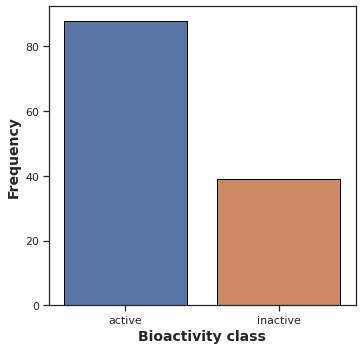

In [20]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Scatter plot of MW versus LogP

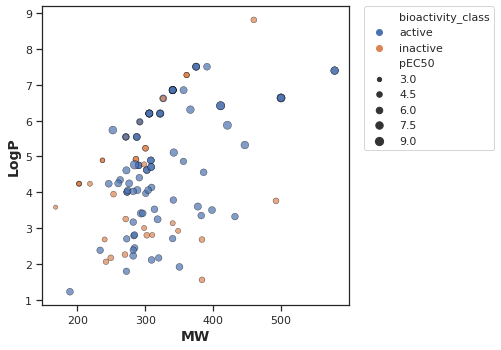

In [21]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pEC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### Box plots and Mann-Whitney U Tests of distributions

In [22]:
def mannwhitney(descriptor, verbose=False):
    # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu
    seed(1)

    # actives and inactives
    selection = [descriptor, 'bioactivity_class']
    df = df_2class[selection]
    active = df[df.bioactivity_class == 'active']
    active = active[descriptor]
    inactive = df[df.bioactivity_class == 'inactive']
    inactive = inactive[descriptor]

    # compare samples
    stat, p = mannwhitneyu(active, inactive)

    # interpret
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'
  
    results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    return results

#### **pEC50 value**

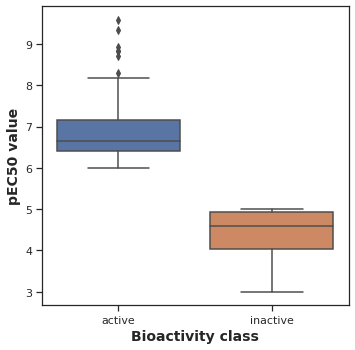

In [23]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pEC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pEC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ec50.pdf')

In [24]:
mannwhitney('pEC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pEC50,0.0,1.523114e-19,0.05,Different distribution (reject H0)


#### **MW**

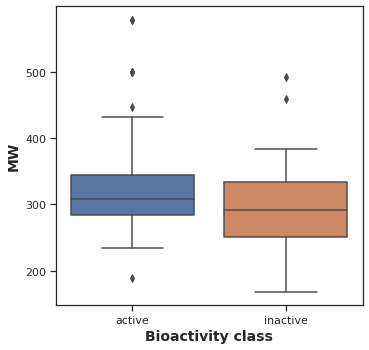

In [25]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [26]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1215.0,0.004445,0.05,Different distribution (reject H0)


#### **LogP**

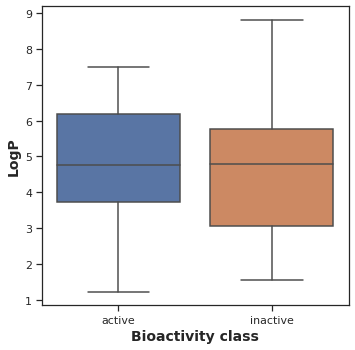

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [28]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1512.5,0.144321,0.05,Same distribution (fail to reject H0)


#### **NumHDonors**

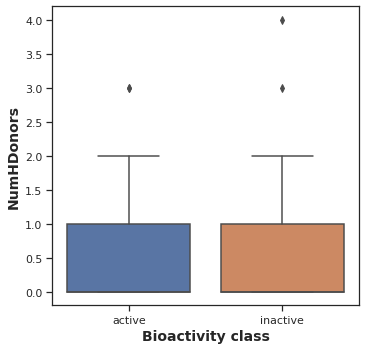

In [29]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [30]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1666.5,0.38532,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

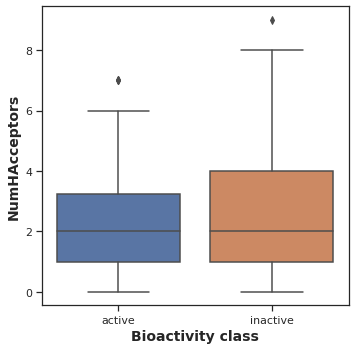

In [31]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [32]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1588.0,0.247259,0.05,Same distribution (fail to reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pEC50 values**

Taking a look at pEC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``EC50 < 1,000 nM = Actives while EC50 > 10,000 nM = Inactives``, corresponding to ``pEC50 > 6 = Actives and pEC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), LogP, NumHDonors and NumHAcceptors exhibited ***no difference*** between the **actives** and **inactives** while the MW shows ***statistically significant difference*** between **actives** and **inactives**.

----

# Descriptor Calculation and Dataset Preparation

## **Download PaDEL-Descriptor**

In [33]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2022-02-02 18:52:01--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Auflösen des Hostnamens github.com (github.com) … 140.82.121.4
Verbindungsaufbau zu github.com (github.com)|140.82.121.4|:443... verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [folgend]
--2022-02-02 18:52:01--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Auflösen des Hostnamens raw.githubusercontent.com (raw.githubusercontent.com) … 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Verbindungsaufbau zu raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 25768637 (25M) [application/zip]
Wird in »padel.zip« gespeichert.

padel.zip           100%[===================>]  24,57M  6,86MB/s    in 3,7s    

2022-02-02 18:52:05 (

In [34]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

  inflating: PaDEL-Descriptor/lib/libPaDEL-Descriptor.jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._libPaDEL-Descriptor.jar  
  inflating: PaDEL-Descriptor/lib/libPaDEL-Jobs(4).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._libPaDEL-Jobs(4).jar  
  inflating: PaDEL-Descriptor/lib/cdk-1.4.15.jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._cdk-1.4.15.jar  
  inflating: PaDEL-Descriptor/lib/ambit2-smarts-2.4.7-SNAPSHOT(5).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._ambit2-smarts-2.4.7-SNAPSHOT(5).jar  
  inflating: PaDEL-Descriptor/lib/ambit2-core-2.4.7-SNAPSHOT(1).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._ambit2-core-2.4.7-SNAPSHOT(1).jar  
  inflating: PaDEL-Descriptor/lib/libPaDEL-Jobs(8).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._libPaDEL-Jobs(8).jar  
  inflating: PaDEL-Descriptor/lib/jgrapht-0.6.0(6).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._jgrapht-0.6.0(6).jar  
  inflating: PaDEL-Descriptor/lib/jama(2).jar  
  inflating: __MACOSX/PaDEL

## Prepare `molecule.smi` file for PaDEL

Use 3-class data (active, inactive, intermediate)

In [35]:
df_padel = df_final[['canonical_smiles', 'molecule_chembl_id']]
df_padel.to_csv('molecule.smi', sep='\t', header=False, index=False)

In [36]:
! cat molecule.smi | head -5

c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34	CHEMBL31184
Clc1ccc2c(c1)oc1cc(Cl)c(Cl)c(Cl)c12	CHEMBL136729
Clc1ccc(-c2cc(Cl)c(Cl)c(Cl)c2Cl)cc1	CHEMBL273442
Clc1cc2oc3ccccc3c2cc1Cl	CHEMBL139585
Clc1ccc2oc3c(Cl)c(Cl)ccc3c2c1	CHEMBL334874


In [37]:
! cat molecule.smi | wc -l

237


## Calculate Pubchem fingerprint descriptors

In [38]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [39]:
! bash padel.sh

Processing CHEMBL31184 in molecule.smi (1/237). 
Processing CHEMBL136729 in molecule.smi (2/237). 
Processing CHEMBL273442 in molecule.smi (3/237). 
Processing CHEMBL139585 in molecule.smi (4/237). 
Processing CHEMBL334874 in molecule.smi (5/237). 
Processing CHEMBL137283 in molecule.smi (7/237). 
Processing CHEMBL136843 in molecule.smi (6/237). 
Processing CHEMBL138121 in molecule.smi (8/237). 
Processing CHEMBL335558 in molecule.smi (9/237). Average speed: 1,84 s/mol.
Processing CHEMBL277497 in molecule.smi (11/237). Average speed: 0,64 s/mol.
Processing CHEMBL136882 in molecule.smi (10/237). Average speed: 0,94 s/mol.
Processing CHEMBL342045 in molecule.smi (12/237). Average speed: 0,49 s/mol.
Processing CHEMBL135555 in molecule.smi (13/237). Average speed: 0,39 s/mol.
Processing CHEMBL136453 in molecule.smi (14/237). Average speed: 0,40 s/mol.
Processing CHEMBL136461 in molecule.smi (15/237). Average speed: 0,29 s/mol.
Processing CHEMBL137304 in molecule.smi (16/237). Average speed

Processing CHEMBL1421125 in molecule.smi (110/237). Average speed: 0,06 s/mol.
Processing CHEMBL1518278 in molecule.smi (111/237). Average speed: 0,06 s/mol.
Processing CHEMBL1577703 in molecule.smi (112/237). Average speed: 0,06 s/mol.
Processing CHEMBL1596262 in molecule.smi (113/237). Average speed: 0,06 s/mol.
Processing CHEMBL1529540 in molecule.smi (114/237). Average speed: 0,06 s/mol.
Processing CHEMBL1577852 in molecule.smi (115/237). Average speed: 0,06 s/mol.
Processing CHEMBL1557667 in molecule.smi (116/237). Average speed: 0,06 s/mol.
Processing CHEMBL1400961 in molecule.smi (117/237). Average speed: 0,06 s/mol.
Processing CHEMBL26138 in molecule.smi (118/237). Average speed: 0,06 s/mol.
Processing CHEMBL1382475 in molecule.smi (120/237). Average speed: 0,06 s/mol.
Processing CHEMBL2006030 in molecule.smi (119/237). Average speed: 0,06 s/mol.
Processing CHEMBL1964748 in molecule.smi (121/237). Average speed: 0,06 s/mol.
Processing CHEMBL3195346 in molecule.smi (122/237). Av

Processing CHEMBL599338 in molecule.smi (214/237). Average speed: 0,05 s/mol.
Processing CHEMBL599322 in molecule.smi (215/237). Average speed: 0,05 s/mol.
Processing CHEMBL26260 in molecule.smi (217/237). Average speed: 0,05 s/mol.
Processing CHEMBL611384 in molecule.smi (216/237). Average speed: 0,05 s/mol.
Processing CHEMBL299155 in molecule.smi (218/237). Average speed: 0,05 s/mol.
Processing CHEMBL3319505 in molecule.smi (219/237). Average speed: 0,05 s/mol.
Processing CHEMBL3319504 in molecule.smi (220/237). Average speed: 0,05 s/mol.
Processing CHEMBL3319503 in molecule.smi (221/237). Average speed: 0,05 s/mol.
Processing CHEMBL3319502 in molecule.smi (222/237). Average speed: 0,05 s/mol.
Processing CHEMBL3319501 in molecule.smi (223/237). Average speed: 0,05 s/mol.
Processing CHEMBL3319500 in molecule.smi (224/237). Average speed: 0,05 s/mol.
Processing CHEMBL3319499 in molecule.smi (225/237). Average speed: 0,05 s/mol.
Processing CHEMBL3319498 in molecule.smi (226/237). Averag

## **Preparing the X and Y Data Matrices**

### **X data matrix**

In [40]:
X = pd.read_csv('descriptors_output.csv')

In [41]:
X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL334874,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL136843,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL136729,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL273442,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL137283,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,CHEMBL312186,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233,CHEMBL26260,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
234,CHEMBL4591417,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
235,CHEMBL4646273,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
X.drop(columns=['Name'], inplace=True)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
233,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
234,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
235,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## **Y variable**

In [43]:
Y = df_final['pEC50']
Y

0      8.301030
1      6.659001
2      5.387000
3      5.326000
4      6.347000
         ...   
233    5.872895
234    7.309804
235    8.075721
236    4.301030
237    9.585027
Name: pEC50, Length: 237, dtype: float64

----

# Regression Model with Random Forest

In [44]:
X.shape

(237, 881)

In [45]:
Y.shape

(237,)

### Remove low variance features

In [46]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_select = selection.fit_transform(X)

In [47]:
X_select.shape

(237, 171)

## Train/test split

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X_select, Y, test_size=0.2)

In [49]:
X_train.shape, Y_train.shape

((189, 171), (189,))

In [50]:
X_test.shape, Y_test.shape

((48, 171), (48,))

## Building a regression model using Random Forest

In [51]:
np.random.seed(0)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

-0.40072945551834027

In [52]:
Y_pred = model.predict(X_test)

## Scatter plot of experimental vs predicted pEC50 values

/home/minimal/anaconda3/envs/ml/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

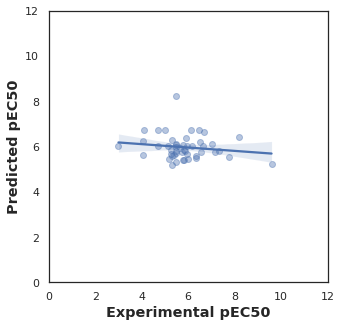

In [53]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pEC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pEC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

----

# Interpretation

The goodness-of-fit of the model is low, probably due to a low number of data points compared to the large number of features (171).

# Use case
Use the model to predict the bioactivity of new compounds towards the target.